In [70]:
import numpy as np
import os
np.set_printoptions(threshold=np.inf, precision=4)
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import skimage.io
from skimage.transform import resize, pyramid_reduce

raw_data_path = '/s/red/b/nobackup/data/eggnog_cpm/test1_paf_hm/20160205_191417_00_Video'
# os.makedirs(os.path.join(raw_path,), exist_ok=True)

In [6]:
def get_heatmap(index_array, pxpy_list):
    # index_array (240/8, 320/8, 2), pxpy_list [px, py]
    alpha = 1.5
    kp_location_array = np.zeros(index_array.shape)
    assert(index_array.shape[0] > 0 and index_array.shape[1] > 0)
    
    if pxpy_list[0] is None:
        heatmap = kp_location_array[:,:,0]
    else:
        kp_location_array[:, :, 0] = pxpy_list[1]
        kp_location_array[:, :, 1] = pxpy_list[0]
        heatmap = np.exp((alpha)*-np.sqrt(np.sum(np.square(index_array - kp_location_array), axis=2)))
        heatmap /= np.max(heatmap)


    #print left, right, heat_map_0.shape, heat_map_1.shape, np.max(heat_map_0), np.max(heat_map_1)

#     if np.sum(heat_map)>0:
#         heat_map /= np.max(heat_map)

#     plt.imshow(heatmap, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
#     plt.show()
#     print(type(heatmap))
    return heatmap


def get_pafx_pafy(index_array, kp0xy, kp1xy):
    """
    kp0xy, kp1xy: lists [pixel_x, pixel_y] for kp0 and kp1
    """
    limb_width = 1.0  # pixels  # for low res pafs
#     limb_width = 1.25*4  # pixels  # for high res pafs
    assert(index_array.shape[0] > 0 and index_array.shape[1] > 0)
    
    paf_array = np.zeros(index_array.shape)  # stores calculated pafs (values between -1 to 1)
    p_vector_array = np.zeros(index_array.shape)  # slice 0 stores all y, slice 1 stores all x
    
    # p_vector_array correpsonds to non-unit vector (p - x(j1, k)) from the paper # j1 is kp0
    # swapeed indexing (0, 1) because slice 0 of index array stores all y locations and slice 1 stores all x locations
    p_vector_array[:,:,0] = index_array[:,:,0] - kp0xy[1]
    p_vector_array[:,:,1] = index_array[:,:,1] - kp0xy[0]
    
    # v_vector_array corresponds to v from the paper
    vect = np.array((kp1xy[1] - kp0xy[1], kp1xy[0] - kp0xy[0])).reshape(1, -1)
#     print("vect", vect)
    v_unit_arr, limb_length_arr = normalize(vect, return_norm=True) # y component at 0th index # x component at 1st index
    v_unit = v_unit_arr[0]
    limb_length = limb_length_arr[0]
#     print("vect unit and limb length", v_unit, limb_length)
    v_perpendicular = [v_unit[1], -v_unit[0]]
#     print("v_perp", v_perpendicular)
    #     v_vector_array[:,:,0] = v_unit[0]  # y component at 0th index
    #     v_vector_array[:,:,1] = v_unit[1]  # x component at 1st index
    
#     print("generating paf for the limb formed by", kp0xy, kp1xy)
    # paf_array = index_array  # this caused gray gradient error
    
    for r in range(paf_array.shape[0]):
        for c in range(paf_array.shape[1]):
#             print("r, c = ", r, c)
            # check if p is "on the limb"
            if (0 <= np.dot(v_unit, [p_vector_array[r,c,0], p_vector_array[r,c,1]]) <= limb_length) and (np.abs(np.dot(v_perpendicular, [p_vector_array[r,c,0], p_vector_array[r,c,1]])) <= limb_width):
                paf_array[r, c, 1] = v_unit[0] # y component of the expected vector is assigned to the 1st channel so that we append PAFs in x and then y order
                paf_array[r, c, 0] = v_unit[1] # x component of the expected vector is assigned to the 0th channel so that we append PAFs in x and then y order
#                 print("x, y", v_unit[1], v_unit[0])
#             else:
#                 print("should assign zero")
    # return paf so that x slice is first (index 0) and the y slice is second (index 1)
    return paf_array

In [3]:
paf_pairs_indices = [[1, 14], [0, 1], [12, 0], [13, 0], 
                    [4, 14], [5, 4], [6, 5], [7, 6], [15, 7], [16, 6],
                    [8, 14], [9, 8], [10, 9], [11, 10], [17, 11], [18, 10],
                    [14, 2], [2, 3]
                    ]

def kpx_kpy_transformer(kp_list):
    # for low res pafs
    kpx_transformed = (kp_list[0]-240)/4.5/8
    kpy_transformed = (kp_list[1])/4.5/8
    
#     # for high res pafs
#     kpx_transformed = (kp_list[0]-240)/4.5
#     kpy_transformed = (kp_list[1])/4.5
    
    return [kpx_transformed, kpy_transformed]


def write_pafs_and_heatmaps(raw_data_path):
    break_count = 0
    break_count_img = 0
    for file in sorted(os.listdir(raw_data_path)):
        
        # jpg downsampling and cropping =====================================================================
        if file.endswith('.jpg') and '240x320' not in file:
            break_count_img += 1
            print("processing image", file)
            
            img = skimage.io.imread(os.path.join(raw_data_path, file))
            print("img shape (h, w, c)", img.shape)  # height, width, channels (rgb)
            # skimage.io.imshow(img)
            
            img_central = img[:, 240:(1920-240), :]
            print("img_central shape (h, w, c)", img_central.shape)  # height, width, channels (rgb)
            #skimage.io.imshow(img_central)
#             plt.figure(0)  
#             plt.imshow(img_central)  
#             plt.show()
            
            # downsample by 4.5
            img_down = resize(img_central, (240, 320, 3))  #, anti_aliasing=False)
            print("img_down shape (h, w, c)", img_down.shape)  # height, width, channels (rgb)
            
            # img_down2 = resize(img_central, (240, 320, 3), anti_aliasing=True)  # not available in skimage 0.13.1
            
            img_down3 = pyramid_reduce(img_central, downscale=4.5)
            print("img_down3 shape (h, w, c)", img_down3.shape)  # height, width, channels (rgb)
            
#             skimage.io.imshow(img_down)
#             plt.figure(1)
#             plt.title('img_down, skimage resize')
#             plt.imshow(img_down)  
#             plt.show()
            
#             plt.figure(3)
#             plt.title('img_down3, skimage pyramid_reduce')
#             plt.imshow(img_down3)  
#             plt.show()
            
            print("final image_down smoothed shape =========================", img_down3.shape)
            skimage.io.imsave(os.path.join(raw_data_path, file[:-4] + "_240x320.jpg"), img_down3)

#             if break_count_img > 0:
#                 break  # break after $break_count images
            
        # npy processing =====================================================================
        if '.npy' in file and "heatmap" not in file and "paf" not in file:
            break_count += 1
            print("processing file", file)
            sk_keypoints = np.load(os.path.join(raw_data_path, file))
            print(sk_keypoints.shape)
            total_heatmaps = sk_keypoints.shape[0]//2


            # for 20 heatmaps =====================================
            for kpn in range(sk_keypoints.shape[0]//2):
                kpx = sk_keypoints[2*kpn]
                kpy = sk_keypoints[2*kpn+1]
                # print(kpx, kpy)
                
                index_array = np.zeros((240//8, 320//8, 2))
                #index_array = np.zeros((270//8, 480//8, 2))
                for i in range(index_array.shape[0]):
                    for j in range(index_array.shape[1]):
                        index_array[i][j] = [i, j]  # height (y), width (x) => index_array[:,:,0] = y pixel coordinate and index_array[:,:,1] = x
                
                if kpn == 0:
                    #heatmap = get_heatmap(index_array, [(kpx-240)/4.5/8, kpy/4.5/8])   # /4 because image is 1080 x 1920 and so are the original pixel locations of the keypoints 
                    heatmap = get_heatmap(index_array, kpx_kpy_transformer([kpx, kpy]))   # /4 because image is 1080 x 1920 and so are the original pixel locations of the keypoints 
                else:
                    #heatmap = np.dstack((heatmap, get_heatmap(index_array, [(kpx-240)/4.5/8, kpy/4.5/8])))
                    heatmap = np.dstack(( heatmap, get_heatmap(index_array, kpx_kpy_transformer([kpx, kpy])) ))
                print("heatmap.shape =", heatmap.shape)
            
            # generate background heatmap
            maxed_heatmap = np.max(heatmap[:,:,:], axis=2)
            # print("maxed_heatmap.shape = ", maxed_heatmap.shape)
            
            #print("background heatmap ==== ")
            #plt.figure(1)
            #plt.imshow(1 - maxed_heatmap, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)  # background color
            #plt.show()
            #print("max, min, background heatmap = ", maxed_heatmap.max(), maxed_heatmap.min())
            
            heatmap = np.dstack((heatmap, 1 - maxed_heatmap))
            print("heatmap.shape =", heatmap.shape)
            np.save(os.path.join(raw_data_path, file[:-4] + "_heatmap30_40.npy"), heatmap)
            
            # for 18x2 PAFs =====================================
            for n, pair in enumerate(paf_pairs_indices):
                print("writing paf for index", n, pair)
                index_array = np.zeros((240//8, 320//8, 2))
#                 index_array = np.zeros((240, 320, 2))
                for i in range(index_array.shape[0]):
                    for j in range(index_array.shape[1]):
                        index_array[i][j] = [i, j]  # height (y), width (x) => index_array[:,:,0] = y pixel coordinate and index_array[:,:,1] = x
                
    
                if n == 0:
                    paf = get_pafx_pafy(index_array, 
                                        kp0xy=kpx_kpy_transformer([sk_keypoints[2*pair[0]], sk_keypoints[2*pair[0]+1]]), 
                                        kp1xy=kpx_kpy_transformer([sk_keypoints[2*pair[1]], sk_keypoints[2*pair[1]+1]]))
                else:
                    paf = np.dstack(( paf,  get_pafx_pafy(index_array, 
                                        kp0xy=kpx_kpy_transformer([sk_keypoints[2*pair[0]], sk_keypoints[2*pair[0]+1]]), 
                                        kp1xy=kpx_kpy_transformer([sk_keypoints[2*pair[1]], sk_keypoints[2*pair[1]+1]]))
                                    ))
                print("paf.shape =", paf.shape)
#                 if n == 0:
#                     break
                    
            print("final paf.shape =========================", paf.shape)
            np.save(os.path.join(raw_data_path, file[:-4] + "_paf30_40.npy"), paf)


            if break_count > 0:
                break  # break after $break_count images
            

In [127]:
write_pafs_and_heatmaps(raw_data_path)

processing image 20160205_191417_00_Video_vfr_100_skfr_99.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)


/s/parsons/h/proj/vision/usr/guru5/Envs/env3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_101_skfr_99.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)


/s/parsons/h/proj/vision/usr/guru5/Envs/env3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_102_skfr_100.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_103_skfr_101.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_104_skfr_101.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_128_skfr_126.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_129_skfr_128.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_12_skfr_11.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_153_skfr_151.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_154_skfr_152.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_155_skfr_153.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_179_skfr_177.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_17_skfr_16.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_180_skfr_179.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_204_skfr_202.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_205_skfr_202.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_206_skfr_203.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_22_skfr_21.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_230_skfr_227.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_231_skfr_228.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_255_skfr_253.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_256_skfr_255.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_257_skfr_255.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_280_skfr_277.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_281_skfr_278.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_282_skfr_280.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_306_skfr_303.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_307_skfr_304.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_308_skfr_306.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_331_skfr_329.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_332_skfr_329.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_333_skfr_330.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_357_skfr_353.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_358_skfr_355.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_359_skfr_355.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_382_skfr_379.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_383_skfr_379.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_384_skfr_381.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_408_skfr_404.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_409_skfr_405.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_40_skfr_39.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_433_skfr_428.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_434_skfr_429.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_435_skfr_430.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_459_skfr_453.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_45_skfr_44.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_460_skfr_455.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_484_skfr_478.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_485_skfr_479.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_486_skfr_481.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_50_skfr_49.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_510_skfr_504.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_511_skfr_504.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processi

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_535_skfr_530.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_536_skfr_530.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_537_skfr_531.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_560_skfr_554.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_561_skfr_555.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_562_skfr_557.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_586_skfr_579.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_587_skfr_581.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_588_skfr_581.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_611_skfr_603.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_612_skfr_603.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_613_skfr_606.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
proces

img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_84_skfr_83.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_85_skfr_83.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing image 20160205_191417_00_Video_vfr_86_skfr_84.jpg
img shape (h, w, c) (1080, 1920, 3)
img_central shape (h, w, c) (1080, 1440, 3)
img_down shape (h, w, c) (240, 320, 3)
img_down3 shape (h, w, c) (240, 320, 3)
final image_down smoothed shape ========================= (240, 320, 3)
processing i

In [100]:
# raw_data_path = "/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/s05/part1_layout_p10/20151114_014908_00_Video/"
# file_pre = "20151114_014908_00_Video_vfr_497_skfr_487"

# testing folders

raw_data_path = "/s/red/b/nobackup/data/eggnog_cpm/from_scratch/0328180100pm/testing/"
# file_pre = "20151116_230144_00_Video_vfr_1005_skfr_996_240x320_test"
file_pre = "20151113_224707_00_Video_vfr_1015_skfr_990_240x320_test"

# raw_data_path = "/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/s07/part1_layout_p14/20151116_230144_00_Video/"
# file_pre = "20151116_230144_00_Video_vfr_1005_skfr_996"
# raw_data_path = "/s/red/b/nobackup/data/eggnog_cpm/eggnog_cpm_test/s04/part1_layout_p08/20151113_224707_00_Video/"
# file_pre = "20151113_224707_00_Video_vfr_1015_skfr_990" 


(30, 40, 36)


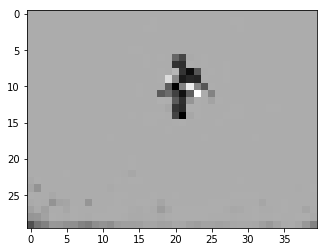

In [101]:
# show pafs

# paf = np.load(os.path.join(raw_data_path, '20160205_191417_00_Video_vfr_100_skfr_99_paf240.npy'))
paf = np.load(os.path.join(raw_data_path, file_pre + '_paf30x40.npy'))
print(paf.shape)  # (30, 40, 36)

summed_paf = np.sum(paf, axis=2)
summed_pafx = np.zeros((paf.shape[0], paf.shape[1]))
summed_pafy = np.zeros((paf.shape[0], paf.shape[1]))

for i in range(paf.shape[2]):
    # print("paf i = ", i)
    if i%2 == 0:
        summed_pafx = summed_pafx + paf[:,:,i]
    else:
        summed_pafy = summed_pafy + paf[:,:,i]
        
#     plt.figure(1)
#     plt.imshow(paf[:,:,i], cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)  
#     plt.show()
        
#     print("max, min, PAF i = ", paf[:,:,i].max(), paf[:,:,i].min())


# plt.figure(2)
# plt.imshow(summed_pafx/paf.shape[2]/2, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)  
# plt.show()

# plt.figure(3)
# plt.imshow(summed_pafy/paf.shape[2]/2, cmap=plt.get_cmap('gray'), vmin=-1, vmax=1)  
# plt.show()

plt.figure(4)  
plt.imshow(summed_paf, cmap=plt.get_cmap('gray'))  
plt.show()
# ******************
# somehow left and right are flipped, but image-limbs perfectly overlap with paf limbs!!!!!
# ******************

# paf_pairs_indices = [[1, 14], [0, 1], [12, 0], [13, 0], 
#                     [4, 14], [5, 4], [6, 5], [7, 6], [15, 7], [16, 6],
#                     [8, 14], [9, 8], [10, 9], [11, 10], [17, 11], [18, 10],
#                     [14, 2], [2, 3]
#                     ]

(30, 40, 20)


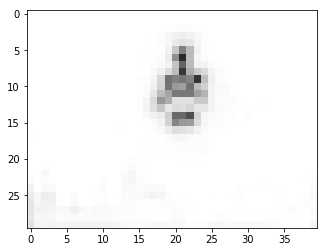

max, min, heatmap i =  1.0006425 0.16134888


In [102]:
# show heatmaps
heatmap = np.load(os.path.join(raw_data_path,  file_pre + '_heatmap30x40.npy'))
print(heatmap.shape)  # (30, 40, 20)

# summed_heatmap = np.sum(heatmap, axis=2)/20

for i in range(heatmap.shape[2]):
    # print("heatmap i = ", i)

    if i == 19:
        plt.figure(1) 
        plt.imshow(heatmap[:,:,i], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)  
        plt.show()
        
        print("max, min, heatmap i = ", heatmap[:,:,i].max(), heatmap[:,:,i].min())

# plt.figure(2)  
# plt.imshow(summed_heatmap, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)  
# plt.show()